In [1]:
from gnn_tracking.training.ml import MLModule
from pathlib import Path

import pandas as pd
import numpy as np
from numpy import ndarray as A
import torch
from gnn_tracking.utils.graph_masks import get_good_node_mask
import matplotlib.pyplot as plt
import tqdm
from functools import partial
from ocpaper231.data import get_dm
import scienceplots
plt.style.use(["science", "notebook"])
from gnn_tracking.training.tc import TCModule

from torch_geometric.data import Data
import torch
from tqdm.contrib.concurrent import process_map
from gnn_tracking.utils.log import logger
logger.setLevel("WARNING")


/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = torch.load("/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_1/data21000_s0.pt")

In [3]:
chkpt_home = Path("/scratch/gpfs/kl5675/checkpoints/animation/")
assert chkpt_home.is_dir()

In [35]:
# def fast_preload(chkpt_path, out_dir, data):
#     model = TCModule.load_from_checkpoint(chkpt_path)
#     out = model(data)["H"].detach().cpu().numpy()
#     step = int(chkpt_path.stem.split("=")[-1])
#     np.save(out_dir / f"{step}.npy", out)

# chkpt_paths = list(chkpt_home.glob("*.ckpt"))
# process_map(partial(fast_preload, out_dir=chkpt_home / "preloaded", data=data), chkpt_paths[174:])

  0%|                                                                            | 0/336 [03:30<?, ?it/s]


: 

: 

In [6]:
class LatentSpaceCollector:
    def __init__(self, data: Data, out_dir: Path):
        out_dir.mkdir(parents=True, exist_ok=True)
        self._data = data
        self.out_dir = out_dir
    
    @staticmethod
    def get_step(path: Path) -> int:
        return int(path.stem.split("=")[-1])
    
    def get_all_latent_spaces(self, chkpt_home: Path, max_i=None):
        chkpt_files = list(chkpt_home.glob("*.ckpt"))
        print(f"Found {len(chkpt_files)} checkpoints")
        chkpts = sorted(chkpt_files, key=self.get_step)[:max_i]
        latent_spaces = []
        for chkpt in tqdm.tqdm(chkpts):
            step = self.get_step(chkpt)
            latent_space = self.get_latent_space(step, chkpt)
            latent_spaces.append(latent_space)
        return latent_spaces
    
    def get_latent_space(self, step: int, chkpt) -> A:
        latent_space = self._load_latent_space(step)
        if latent_space is None:
            latent_space = self._get_fresh_latent_space(chkpt)
            self._save_latent_space(latent_space, step)
        return latent_space

    def _load_latent_space(self, step: int) -> A|None:
        path = self.out_dir / f"{step}.npy" 
        if path.is_file():
            return np.load(path)

    def _save_latent_space(self, latent_space: A, step: int):
        np.save(self.out_dir / f"{step}.npy", latent_space)

    def _get_fresh_latent_space(self, chkpt):
        model = TCModule.load_from_checkpoint(chkpt)
        return model(self._data)["H"].detach().cpu().numpy()



In [7]:
lsc = LatentSpaceCollector(data, chkpt_home / "latent_spaces")
spaces = lsc.get_all_latent_spaces(chkpt_home, max_i=170)

Found 538 checkpoints


100%|█████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 538.46it/s]


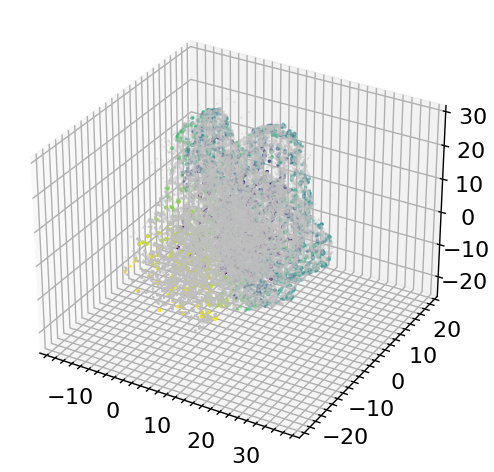

In [8]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
mask = get_good_node_mask(data)
h = spaces[-1][mask]
hn = spaces[-1][~mask]
ax.scatter(hn[:, 0], hn[:, 1], hn[:, 2], alpha=0.3, c="silver", s=0.3)
ax.scatter(h[:, 0], h[:, 1], h[:, 2], alpha=0.4, c=data.eta[mask], cmap="viridis", s=2)

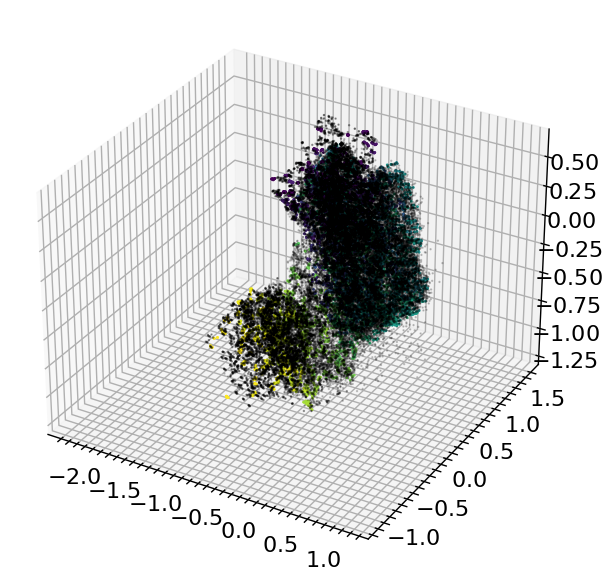

In [16]:
import matplotlib.animation  as animation
from gnn_tracking.analysis.latent import get_color_mapper 


class Animator:
    def __init__(self, data: Data, latent_spaces: list[A], selected_pids=None):
        self._data = data
        self._latent_spaces = latent_spaces
        if selected_pids is None:
            selected_pids = np.random.choice(data.particle_id[get_good_node_mask(data)].unique(), 6)
        self._color_mapper = get_color_mapper(selected_pids)
        self._selected_pid_mask = np.isin(data.particle_id, selected_pids)
        self._normalized_hs = []


    def normalize_h(self, h: A) -> A:
        h -= h.mean(axis=0)
        new_norm = h.sum(axis=1).std(axis=0)
        self._normalized_hs.append(h / new_norm)
        return np.array(self._normalized_hs)[-3:].mean(axis=0)

    def animate(self, dims=(0, 1), show_noise=True, show_selected=True):
        fig = plt.figure()
        fig.tight_layout()
        if len(dims) == 3:
            ax = fig.add_subplot(projection='3d')
        elif len(dims) == 2:
            ax = fig.add_subplot()
        else:
            raise ValueError("dims must be 2 or 3")

        mask = get_good_node_mask(data)
        h = self.normalize_h(self._latent_spaces[0])

        noise_args = [h[~mask, d] for d in dims]
        oi_args = [h[mask, d] for d in dims]
        selected_args = [h[self._selected_pid_mask, d] for d in dims]

        if show_noise:
            sc_noise = ax.scatter(
                *noise_args,
                alpha=0.2, 
                s=0.5, 
                c="black"
            )
        sc = ax.scatter(
            *oi_args,
            alpha=1,
            s=1,
            #c="black", 
            c=self._data.eta[mask], cmap="viridis"
            )
        if show_selected:
            sc3 = ax.scatter(
                *selected_args,
                marker="o",
                facecolors="none",
                edgecolors=self._color_mapper(self._data.particle_id[self._selected_pid_mask]),
                linewidths=2.0,
                s=26,
                alpha=1,
            )
        fig.tight_layout()

        def update(frame):
            # Update scatter plot data for the current frame
            h = self.normalize_h(self._latent_spaces[frame])
            noise_args = [h[~mask, d] for d in dims]
            oi_args = [h[mask, d] for d in dims]
            selected_args = [h[self._selected_pid_mask, d] for d in dims]
            if len(dims) == 2:
                if show_noise:
                    sc_noise.set_offsets(np.column_stack(noise_args))
                sc.set_offsets(np.column_stack(oi_args))
                if show_selected:
                    sc3.set_offsets(np.column_stack(selected_args))
            else:
                if show_noise:
                    sc_noise._offsets3d = tuple(noise_args)
                sc._offsets3d = tuple(oi_args)
                if show_selected:
                    sc3._offsets3d = tuple(selected_args)

        # Create animation, assuming len(self._latent_spaces) frames
        return animation.FuncAnimation(fig, update, frames=len(self._latent_spaces), blit=False)

a = Animator(data, spaces)
anim = a.animate(dims=(0, 1, 2), show_noise=True, show_selected=False) 
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, bitrate=1800)
anim.save('/home/kl5675/Documents/23/git_sync/klieret-gnn-tracking-experiments/notebooks/0051_0100/latent_spaces_animation_noise.mp4', writer=writer)